In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import copy

from typing import List, Optional
from torch.utils.data import Dataset

from rdkit import Chem
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

# PyTorch Geometric containers only (no torch_scatter required)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from rdkit import Chem
from gnn_model import DualMPNN


from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
cep_path = "/Users/williamsilver/Ai in materials workshop/AI-in-materials-workshop/AI-in-materials-workshop/41597_2016_BFsdata201686_MOESM94_ESM.csv" 
cep = pd.read_csv(cep_path)

In [3]:
df = pd.read_csv("/Users/williamsilver/Ai in materials workshop/AI-in-materials-workshop/AI-in-materials-workshop/mmc2_cleaned_2_no_zero_pce.csv")

In [4]:
COMMON_ATOMIC_NUMS = [1, 5, 6, 7, 8, 9, 14, 15, 16, 17, 35, 53]
ATOMNUM_TO_IDX = {z: i for i, z in enumerate(COMMON_ATOMIC_NUMS)}
ATOM_FDIM = len(COMMON_ATOMIC_NUMS) + 6

BOND_TYPES = [
    Chem.rdchem.BondType.SINGLE,
    Chem.rdchem.BondType.DOUBLE,
    Chem.rdchem.BondType.TRIPLE,
    Chem.rdchem.BondType.AROMATIC,
]
BOND_TO_IDX = {bt: i for i, bt in enumerate(BOND_TYPES)}
BOND_FDIM = len(BOND_TYPES) + 2


def atom_features(atom: Chem.rdchem.Atom) -> List[float]:
    z = atom.GetAtomicNum()
    onehot = [0.0] * len(COMMON_ATOMIC_NUMS)
    if z in ATOMNUM_TO_IDX:
        onehot[ATOMNUM_TO_IDX[z]] = 1.0

    degree = float(atom.GetDegree())
    formal_charge = float(atom.GetFormalCharge())
    aromatic = 1.0 if atom.GetIsAromatic() else 0.0
    total_h = float(atom.GetTotalNumHs())

    hybrid = atom.GetHybridization()
    hyb_map = {
        Chem.rdchem.HybridizationType.SP: 1.0,
        Chem.rdchem.HybridizationType.SP2: 2.0,
        Chem.rdchem.HybridizationType.SP3: 3.0,
    }
    hyb_val = hyb_map.get(hybrid, 0.0)
    in_ring = 1.0 if atom.IsInRing() else 0.0

    return onehot + [degree, formal_charge, aromatic, total_h, hyb_val, in_ring]


def bond_features(bond: Chem.rdchem.Bond) -> List[float]:
    bt = bond.GetBondType()
    onehot = [0.0] * len(BOND_TYPES)
    if bt in BOND_TO_IDX:
        onehot[BOND_TO_IDX[bt]] = 1.0
    conjugated = 1.0 if bond.GetIsConjugated() else 0.0
    in_ring = 1.0 if bond.IsInRing() else 0.0
    return onehot + [conjugated, in_ring]


def smiles_to_data(smiles: str, y: np.ndarray) -> Optional[Data]:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    x = torch.tensor([atom_features(a) for a in mol.GetAtoms()], dtype=torch.float32)

    edge_index = []
    edge_attr = []
    for b in mol.GetBonds():
        i = b.GetBeginAtomIdx()
        j = b.GetEndAtomIdx()
        bf = bond_features(b)
        edge_index.append([i, j])
        edge_index.append([j, i])
        edge_attr.append(bf)
        edge_attr.append(bf)

    if len(edge_index) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, BOND_FDIM), dtype=torch.float32)
    else:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float32)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=torch.tensor(y, dtype=torch.float32))


In [5]:
def load_pretrained(path, model_ctor, device):
    ckpt = torch.load(path, map_location="cpu")
    mean = ckpt["mean"].astype(np.float32)
    std = ckpt["std"].astype(np.float32)

    mcfg = ckpt["model_cfg"]
    model = model_ctor(
        node_in=ATOM_FDIM,
        edge_in=BOND_FDIM,
        hidden_dim=mcfg["hidden_dim"],
        msg_dim=mcfg["msg_dim"],
        num_layers=mcfg["num_layers"],
        dropout=mcfg["dropout"],
        out_dim=4,
    ).to(device)

    model.load_state_dict(ckpt["state_dict"], strict=True)
    return model, mean, std, ckpt


device = torch.device("cpu")  # good for this finetune size
# IMPORTANT: DualMPNN must be defined/imported in this notebook
model_ft, pre_mean, pre_std, ckpt = load_pretrained("pretrained_gnn.pt", DualMPNN, device)
print("Loaded pretrained model on", device)


Loaded pretrained model on cpu


In [6]:
TARGET3 = ("homo", "lumo", "gap")
IDX3 = np.array([0, 1, 2], dtype=np.int64)

class CepDataset(Dataset):
    def __init__(self, cep, smiles_col, y_cols, pre_mean, pre_std):
        self.df = cep.reset_index(drop=True)
        self.smiles_col = smiles_col
        self.y_cols = y_cols
        self.pre_mean = pre_mean
        self.pre_std = pre_std

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        smiles = row[self.smiles_col]
        y3 = row[list(self.y_cols)].to_numpy(np.float32)  # (3,)

        # standardise using PRETRAIN mean/std for dims 0..2
        y3_std = (y3 - self.pre_mean[IDX3]) / (self.pre_std[IDX3] + 1e-8)

        data = smiles_to_data(smiles, y=np.zeros(4, dtype=np.float32))
        if data is None:
            x = torch.zeros((1, ATOM_FDIM), dtype=torch.float32)
            edge_index = torch.empty((2, 0), dtype=torch.long)
            edge_attr = torch.empty((0, BOND_FDIM), dtype=torch.float32)
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=torch.zeros(4))

        data.y3 = torch.tensor(y3_std, dtype=torch.float32)
        return data


In [13]:
def split_cep(cep, seed=42):
    train_df, temp_df = train_test_split(cep, test_size=0.20, random_state=seed)
    val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=seed)
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)


train_df, val_df, test_df = split_cep(cep, seed=42)

train_ds = CepDataset(train_df, "smiles", TARGET3, pre_mean, pre_std)
val_ds   = CepDataset(val_df,   "smiles", TARGET3, pre_mean, pre_std)
test_ds  = CepDataset(test_df,  "smiles", TARGET3, pre_mean, pre_std)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=0)

In [14]:
def freeze_pce_row_in_last_linear(model): 
    last_linear = None
    for m in model.modules():
        if isinstance(m, torch.nn.Linear):
            last_linear = m
    if last_linear is None or last_linear.out_features != 4:
        print("Could not find a last linear layer with out_features=4; skipping.")
        return

    def hook_w(grad):
        grad = grad.clone()
        grad[3, :] = 0
        return grad

    def hook_b(grad):
        grad = grad.clone()
        grad[3] = 0
        return grad

    last_linear.weight.register_hook(hook_w)
    last_linear.bias.register_hook(hook_b)
    print("Will prevent updates to PCE output row in final linear layer.")

freeze_pce_row_in_last_linear(model_ft)

Will prevent updates to PCE output row in final linear layer.


In [15]:
@torch.no_grad()
def eval_cep(model, loader, device):
    model.eval()
    losses = []
    pred3 = []
    true3 = []
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)           # [B,4] standardised
        out3 = out[:, IDX3]          # [B,3]
        y3 = batch.y3.view_as(out3)  # [B,3]
        loss = F.smooth_l1_loss(out3, y3)
        losses.append(loss.item())
        pred3.append(out3.detach().cpu())
        true3.append(y3.detach().cpu())
    return float(np.mean(losses)), torch.cat(pred3).numpy(), torch.cat(true3).numpy()

def finetune_on_cep(model, train_loader, val_loader, device, lr=1e-2, weight_decay=1e-4, max_epochs=500, patience=20, grad_clip=2.0):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val = float("inf")
    best_state = None
    bad = 0
    for epoch in range(1, max_epochs + 1):
        model.train()
        tr_losses = []
        for batch in train_loader:
            batch = batch.to(device)
            opt.zero_grad(set_to_none=True)
            out = model(batch)
            out3 = out[:, IDX3]
            y3 = batch.y3.view_as(out3)
            loss = F.smooth_l1_loss(out3, y3)
            loss.backward()
            if grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            opt.step()
            tr_losses.append(loss.item())
        val_loss, _, _ = eval_cep(model, val_loader, device)
        tr_loss = float(np.mean(tr_losses))
        print(f"epoch {epoch:03d} | train {tr_loss:.4f} | val {val_loss:.4f}")
        if val_loss < best_val - 1e-4:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
        if bad >= patience:
            print("Early stopping.")
            break
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

model_ft = finetune_on_cep(model_ft, train_loader, val_loader, device)

epoch 001 | train 27.4324 | val 2.2314
epoch 002 | train 2.2016 | val 1.2306
epoch 003 | train 1.5387 | val 1.4806
epoch 004 | train 1.5248 | val 0.8982
epoch 005 | train 1.0586 | val 0.7518
epoch 006 | train 1.2255 | val 2.0177
epoch 007 | train 1.9178 | val 0.9511
epoch 008 | train 1.6314 | val 1.1224
epoch 009 | train 1.2415 | val 0.6679
epoch 010 | train 0.9489 | val 0.6114
epoch 011 | train 0.8341 | val 0.6425
epoch 012 | train 0.8231 | val 0.6210
epoch 013 | train 0.6698 | val 0.4138
epoch 014 | train 0.6303 | val 0.4463
epoch 015 | train 0.7105 | val 0.2751
epoch 016 | train 0.7348 | val 0.3455
epoch 017 | train 0.6071 | val 0.3969
epoch 018 | train 0.5947 | val 0.2677
epoch 019 | train 0.6437 | val 0.6417
epoch 020 | train 1.0182 | val 1.1953
epoch 021 | train 1.1907 | val 1.3906
epoch 022 | train 0.9239 | val 0.6523
epoch 023 | train 0.5504 | val 0.6049
epoch 024 | train 0.6388 | val 0.3864
epoch 025 | train 0.5354 | val 0.3302
epoch 026 | train 0.6070 | val 0.3344
epoch 027 |

In [16]:
import matplotlib.pyplot as plt


# --- helpers ---
def unstandardise_y3(y3_std, pre_mean, pre_std):
    # y3_std: (N,3) for homo/lumo/gap, standardised using pretrained mean/std
    return y3_std * (pre_std[IDX3] + 1e-8) + pre_mean[IDX3]

@torch.no_grad()
def predict_y3_std(model, loader, device):
    """Return model preds and true values in STANDARDISED space: both (N,3)."""
    model.eval()
    pred3, true3 = [], []
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)           # [B,4] standardised
        out3 = out[:, IDX3]          # [B,3]
        y3 = batch.y3.view_as(out3)  # [B,3] standardised
        pred3.append(out3.detach().cpu())
        true3.append(y3.detach().cpu())
    return torch.cat(pred3).numpy(), torch.cat(true3).numpy()

In [17]:
# --- 5-fold OOF on the FULL dataset (cep) ---
seed = 42
device = torch.device("cpu")

kf = KFold(n_splits=5, shuffle=True, random_state=seed)
N = len(cep)

oof_pred_std = np.full((N, 3), np.nan, dtype=np.float32)
oof_true_std = np.full((N, 3), np.nan, dtype=np.float32)

for fold, (tr_idx, te_idx) in enumerate(kf.split(np.arange(N)), start=1):
    print(f"\n===== FOLD {fold}/5 =====")

    # split fold-train into train/val for early stopping
    tr_sub_idx, va_sub_idx = train_test_split(
        tr_idx, test_size=0.15, random_state=seed, shuffle=True
    )

    fold_train_df = cep.iloc[tr_sub_idx].reset_index(drop=True)
    fold_val_df   = cep.iloc[va_sub_idx].reset_index(drop=True)
    fold_test_df  = cep.iloc[te_idx].reset_index(drop=True)

    fold_train_ds = CepDataset(fold_train_df, "smiles", TARGET3, pre_mean, pre_std)
    fold_val_ds   = CepDataset(fold_val_df,   "smiles", TARGET3, pre_mean, pre_std)
    fold_test_ds  = CepDataset(fold_test_df,  "smiles", TARGET3, pre_mean, pre_std)

    fold_train_loader = DataLoader(fold_train_ds, batch_size=64,  shuffle=True,  num_workers=0)
    fold_val_loader   = DataLoader(fold_val_ds,   batch_size=128, shuffle=False, num_workers=0)
    fold_test_loader  = DataLoader(fold_test_ds,  batch_size=128, shuffle=False, num_workers=0)

    # IMPORTANT: reload pretrained weights each fold (so folds are independent)
    model, _, _, _ = load_pretrained("pretrained_gnn.pt", DualMPNN, device)

    # finetune
    model = finetune_on_cep(
        model,
        fold_train_loader,
        fold_val_loader,
        device,
        lr=1e-4,
        weight_decay=1e-4,
        max_epochs=200,
        patience=20,
        grad_clip=2.0
    )

    # predict on fold held-out
    pred_std, true_std = predict_y3_std(model, fold_test_loader, device)

    # store back into the correct rows (te_idx are indices into the ORIGINAL cep)
    oof_pred_std[te_idx] = pred_std.astype(np.float32)
    oof_true_std[te_idx] = true_std.astype(np.float32)

# sanity check: should have no NaNs
assert np.isfinite(oof_pred_std).all(), "Some OOF predictions are missing (NaNs)."
assert np.isfinite(oof_true_std).all(), "Some OOF true values are missing (NaNs)."

# --- convert to ORIGINAL units ---
oof_pred = unstandardise_y3(oof_pred_std, pre_mean, pre_std)  # (N,3)
oof_true = unstandardise_y3(oof_true_std, pre_mean, pre_std)  # (N,3)

# --- R2 per target ---
target_names = ["homo", "lumo", "gap"]
r2s = {name: r2_score(oof_true[:, i], oof_pred[:, i]) for i, name in enumerate(target_names)}
print("\nOOF R2:")
for k, v in r2s.items():
    print(f"  {k:>4s}: {v:.4f}")



===== FOLD 1/5 =====
epoch 001 | train 5.2449 | val 4.6008
epoch 002 | train 4.3673 | val 3.7274
epoch 003 | train 3.4863 | val 2.8744
epoch 004 | train 2.5641 | val 1.9819
epoch 005 | train 1.7294 | val 1.0049
epoch 006 | train 0.9130 | val 0.6682
epoch 007 | train 0.9572 | val 0.8516
epoch 008 | train 1.0703 | val 0.7523
epoch 009 | train 0.9071 | val 0.6120
epoch 010 | train 0.8677 | val 0.6543
epoch 011 | train 0.8023 | val 0.6194
epoch 012 | train 0.7783 | val 0.5728
epoch 013 | train 0.8418 | val 0.5634
epoch 014 | train 0.8112 | val 0.5450
epoch 015 | train 0.7313 | val 0.5197
epoch 016 | train 0.7000 | val 0.5115
epoch 017 | train 0.6184 | val 0.4821
epoch 018 | train 0.6585 | val 0.4589
epoch 019 | train 0.5220 | val 0.4463
epoch 020 | train 0.5764 | val 0.4123
epoch 021 | train 0.5886 | val 0.3939
epoch 022 | train 0.5732 | val 0.3914
epoch 023 | train 0.5382 | val 0.3877
epoch 024 | train 0.5443 | val 0.3498
epoch 025 | train 0.4806 | val 0.3338
epoch 026 | train 0.5281 | v

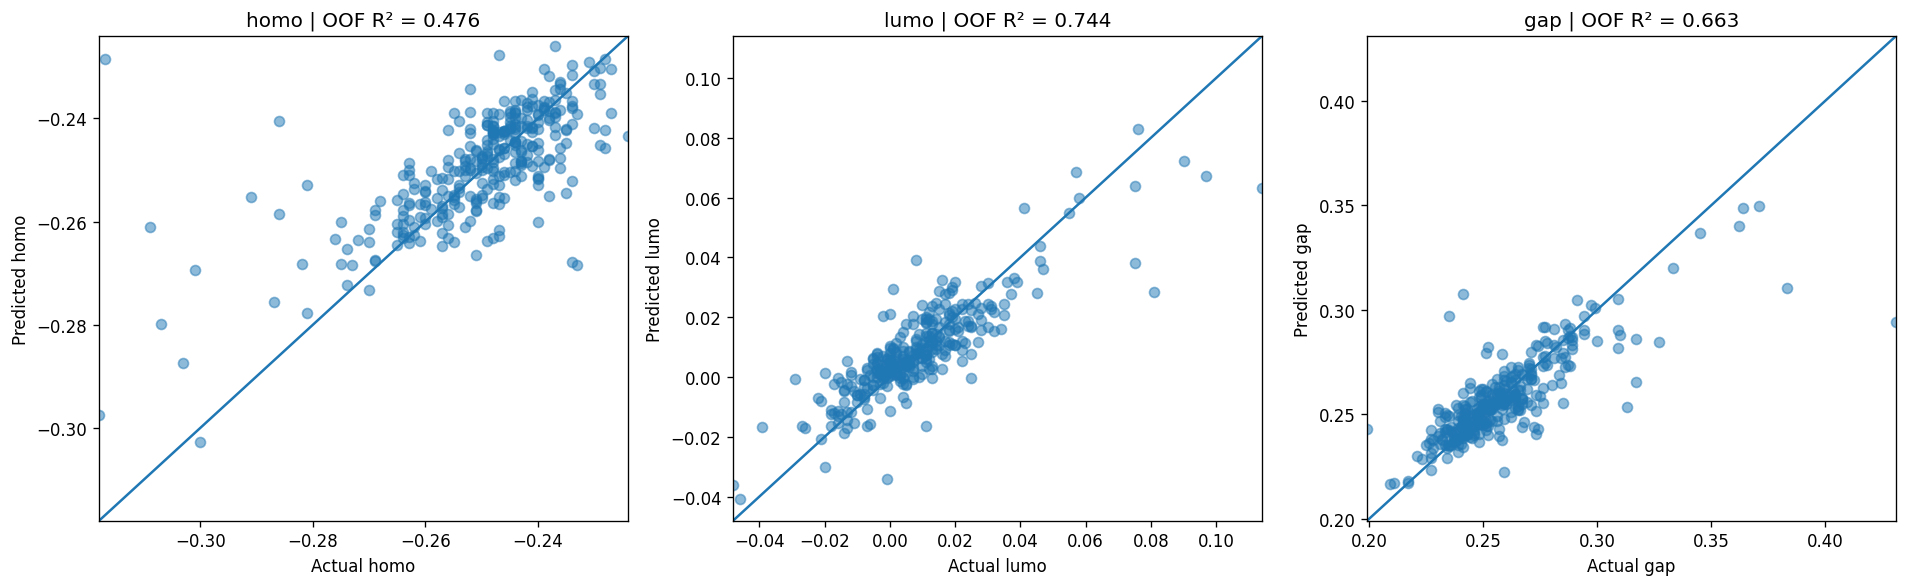

In [18]:
# --- plots: actual vs predicted for each target ---
fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=120)

for i, name in enumerate(target_names):
    ax = axes[i]
    y = oof_true[:, i]
    p = oof_pred[:, i]

    ax.scatter(y, p, alpha=0.5)
    lo = float(min(y.min(), p.min()))
    hi = float(max(y.max(), p.max()))
    ax.plot([lo, hi], [lo, hi])  # y=x
    ax.set_xlabel(f"Actual {name}")
    ax.set_ylabel(f"Predicted {name}")
    ax.set_title(f"{name} | OOF R² = {r2s[name]:.3f}")
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)

plt.tight_layout()
plt.show()

In [24]:
plt.figure(figsize=(7, 5))
plt.bar(target_names_3, rmses, color=colors_3)
plt.ylabel("RMSE")
plt.title("CEP Fine-tuned Model: RMSE by Target")

for i, v in enumerate(rmses):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

NameError: name 'target_names_3' is not defined

<Figure size 700x500 with 0 Axes>